In [5]:
!nvidia-smi

Wed Apr  6 22:50:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cp "./drive/MyDrive/zerowaste-f-final.zip" ./
!unzip "./zerowaste-f-final.zip"

In [ ]:
# ----- #
# Install detectron2
# ----- #
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!gcc --version
# opencv is pre-installed on colab
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

In [6]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import os
import numpy as np
import cv2
import json
import random
from PIL import Image
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode

In [8]:
import json
 
def json2dict(path):
    with open(path) as f:
        return json.load(f)
        
labels_train = json2dict("./splits_final_deblurred/train/labels.json")

img_all = labels_train["images"]
anno_raw = labels_train["annotations"]
anno_all = [list() for idx in range(3002)]

for idx in range(len(anno_raw)):
    tmp = anno_raw[idx]
    idx_img = tmp["image_id"]
    anno_all[idx_img].append(tmp)

In [4]:
img_all[0]

{'coco_url': None,
 'file_name': '01_frame_001160.PNG',
 'height': 1080,
 'id': 0,
 'license': None,
 'width': 1920}

In [9]:
def get_zerowaste_dicts():
    dataset_dicts = []
    for idx0 in range(len(img_all)):
        record = dict()
        tmp = img_all[idx0]
        record["file_name"] = os.path.join("./splits_final_deblurred/train/data", tmp["file_name"])
        record["image_id"] = tmp["id"]
        record["width"] = tmp["width"]
        record["height"] = tmp["height"]
        
        tmp_tmp = anno_all[idx0]
        objs = list()
        for item in tmp_tmp:
            obj = dict()
            obj["bbox"] = item["bbox"]
            obj["bbox_mode"] = BoxMode.XYWH_ABS
            obj["segmentation"] = item["segmentation"]
            obj["category_id"] = item["category_id"] - 1
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

DatasetCatalog.clear()
DatasetCatalog.register("zerowaste_train", get_zerowaste_dicts)
MetadataCatalog.get("zerowaste_train").set(thing_classes=["class0", "class1", "class2", "class3"])
zerowaste_metadata = MetadataCatalog.get("zerowaste_train")

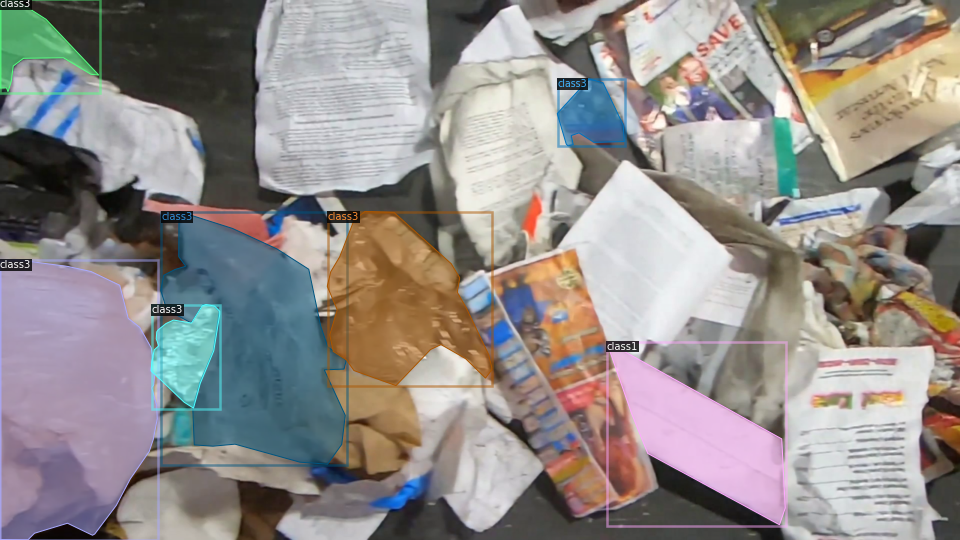

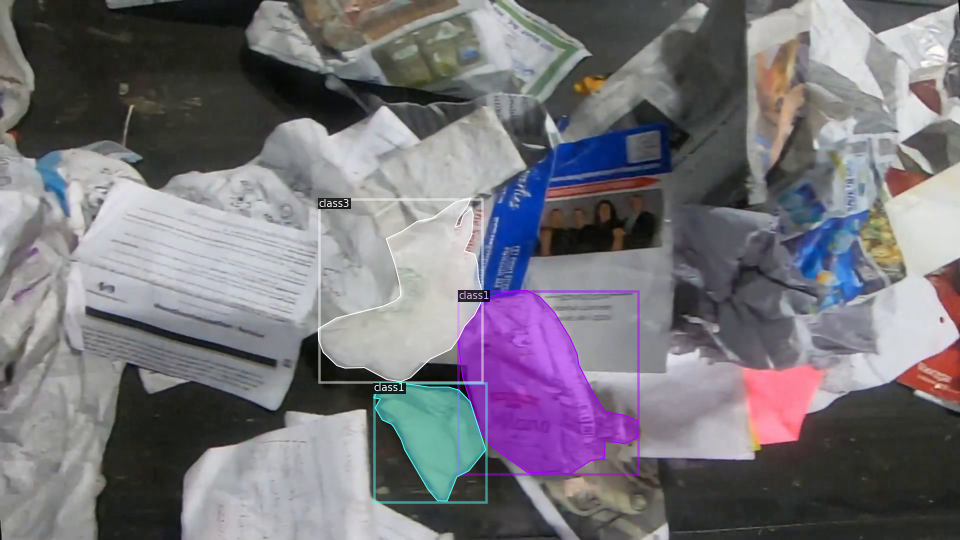

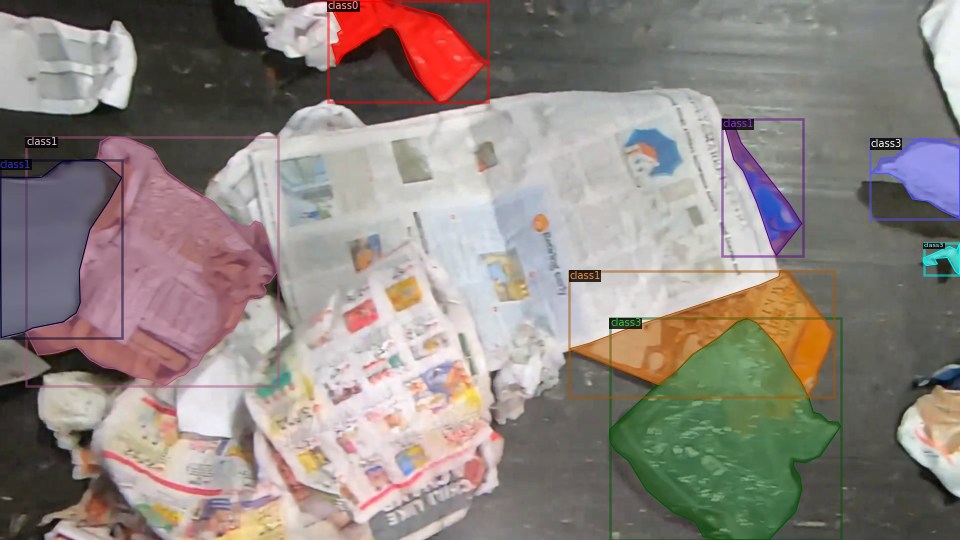

In [10]:
dataset_dicts = get_zerowaste_dicts()
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=zerowaste_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [29]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("zerowaste_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.01  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # we have 4 classes

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/07 00:16:55 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (4, 256, 1, 1) 

[04/07 00:16:57 d2.engine.train_loop]: Starting training from iteration 0
[04/07 00:17:05 d2.utils.events]:  eta: 0:06:38  iter: 19  total_loss: 2.902  loss_cls: 1.264  loss_box_reg: 0.785  loss_mask: 0.684  loss_rpn_cls: 0.089  loss_rpn_loc: 0.030  time: 0.4031  data_time: 0.0383  lr: 0.000200  max_mem: 3351M
[04/07 00:17:13 d2.utils.events]:  eta: 0:06:30  iter: 39  total_loss: 2.318  loss_cls: 0.758  loss_box_reg: 0.826  loss_mask: 0.615  loss_rpn_cls: 0.054  loss_rpn_loc: 0.035  time: 0.4051  data_time: 0.0101  lr: 0.000400  max_mem: 3351M
[04/07 00:17:22 d2.utils.events]:  eta: 0:06:22  iter: 59  total_loss: 2.097  loss_cls: 0.676  loss_box_reg: 0.829  loss_mask: 0.476  loss_rpn_cls: 0.063  loss_rpn_loc: 0.033  time: 0.4062  data_time: 0.0090  lr: 0.000599  max_mem: 3351M
[04/07 00:17:30 d2.utils.events]:  eta: 0:06:15  iter: 79  total_loss: 1.859  loss_cls: 0.620  loss_box_reg: 0.782  loss_mask: 0.355  loss_rpn_cls: 0.051  loss_rpn_loc: 0.031  time: 0.4090  data_time: 0.0112  lr:

In [32]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set the testing threshold for this model
cfg.DATASETS.TEST = ("zerowaste_train", )
predictor = DefaultPredictor(cfg)

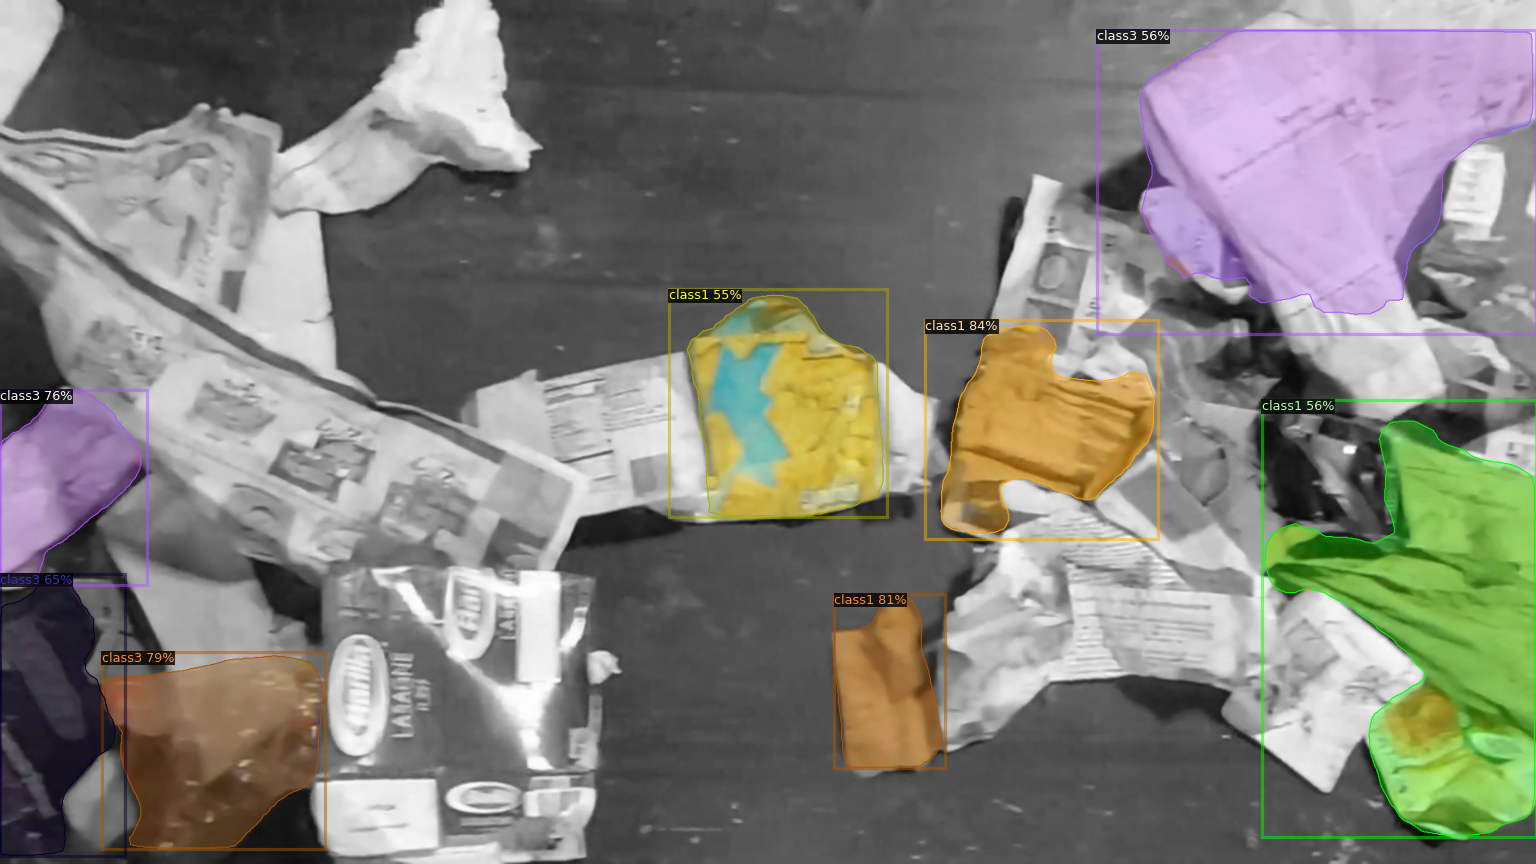

In [33]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_zerowaste_dicts()
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                    metadata=zerowaste_metadata, 
                    scale=0.8, 
                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])